In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train = pd.read_csv("~/.kaggle/competitions/titanic/train.csv")
test = pd.read_csv("~/.kaggle/competitions/titanic/test.csv")
IDtest = test["PassengerId"]

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

/home/bijan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [7]:
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

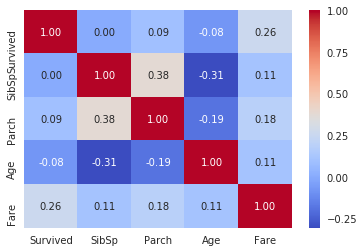

In [8]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

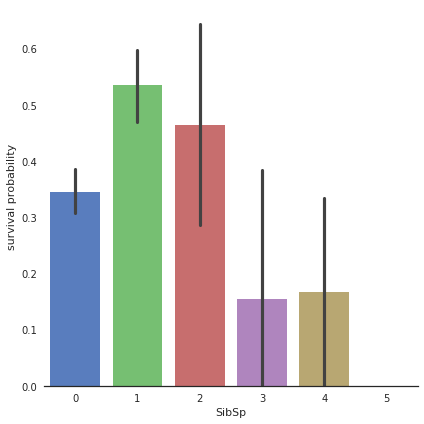

In [9]:
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

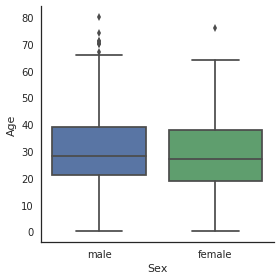

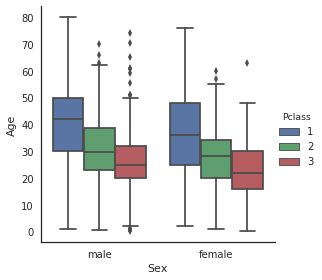

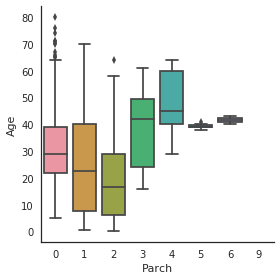

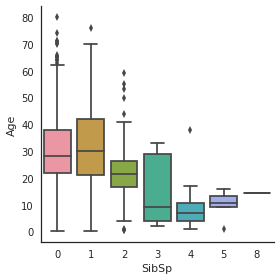

In [10]:
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [11]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [12]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/home/bijan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [14]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [15]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [16]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

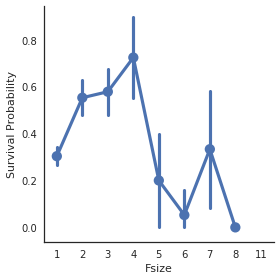

In [17]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [18]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [19]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [20]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [21]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [22]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [23]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [24]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [25]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [26]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/home/bijan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
dataset.head()
train.describe()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,...,881.000000,881.000000,881.0,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,29.202804,31.121566,0.363224,0.350738,0.455165,0.385925,1.818388,0.609535,0.182747,0.148695,...,0.013621,0.006810,0.0,0.002270,0.011351,0.003405,0.746879,0.241771,0.208854,0.549376
std,13.422341,47.996249,0.791839,0.477472,0.871571,0.487090,1.382086,0.488132,0.386678,0.355989,...,0.115977,0.082291,0.0,0.047619,0.105994,0.058288,0.435047,0.428399,0.406720,0.497839
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.895800,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,14.454200,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,37.000000,30.500000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,1.000000,5.000000,1.000000,8.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
## Separate train features and label 
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)


/home/bijan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

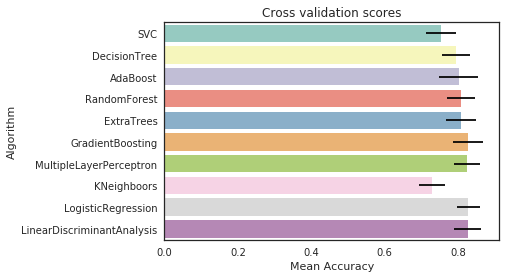

In [30]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=12))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [31]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1120 out of 1120 | elapsed:    1.3s finished


In [32]:
gsadaDTC.best_score_

0.8217934165720772

In [33]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    5.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   12.6s
[Parallel(n_jobs=12)]: Done 540 out of 540 | elapsed:   16.0s finished


0.8308740068104427

In [34]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    5.4s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   13.7s
[Parallel(n_jobs=12)]: Done 540 out of 540 | elapsed:   17.7s finished


0.8376844494892168

In [35]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=12)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 720 out of 720 | elapsed:    7.9s finished


0.8342792281498297

In [36]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    6.2s
[Parallel(n_jobs=12)]: Done 280 out of 280 | elapsed:   11.4s finished


0.8217934165720772

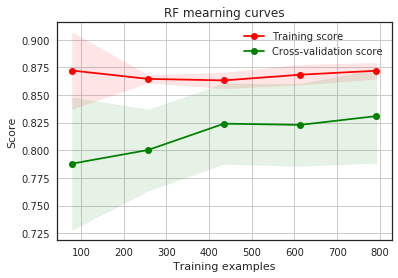

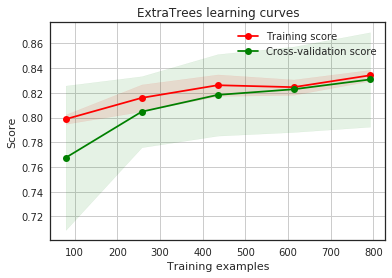

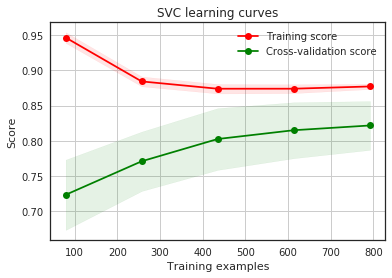

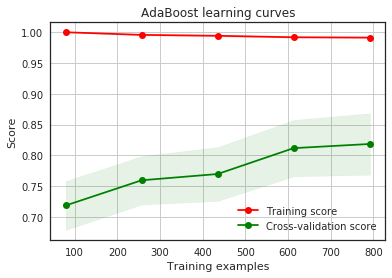

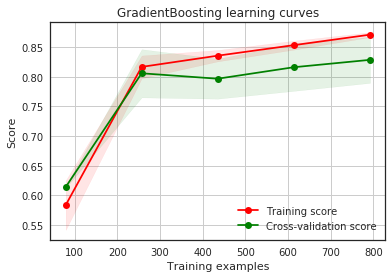

In [37]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

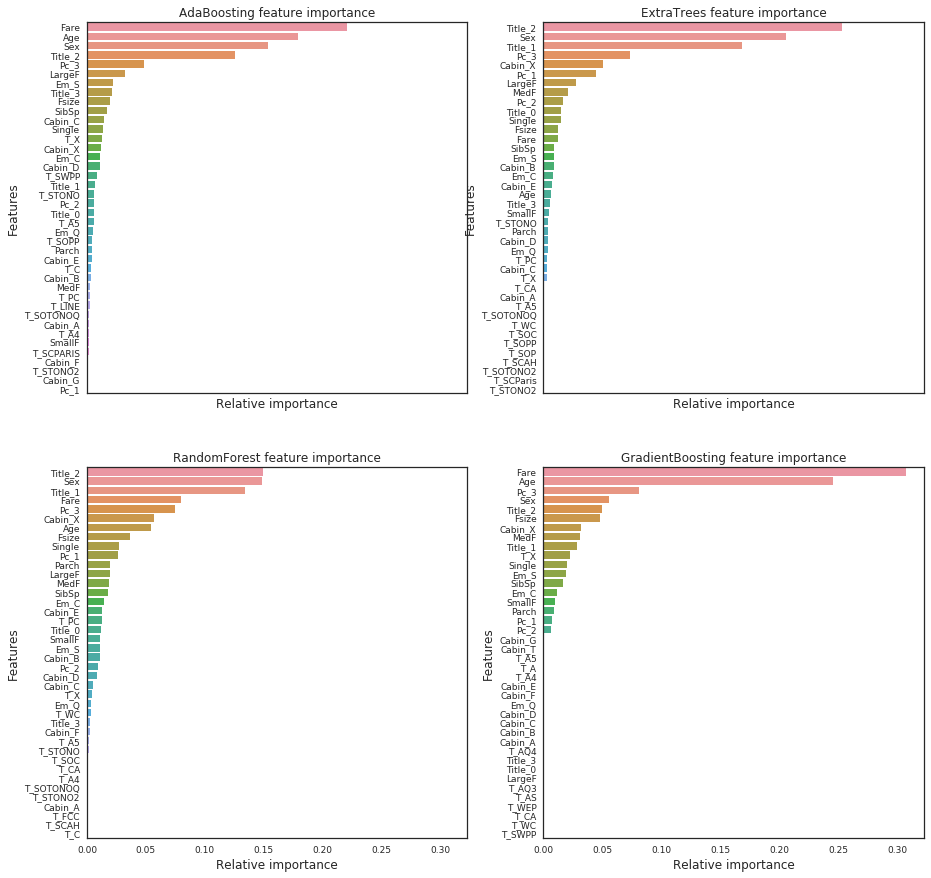

In [38]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

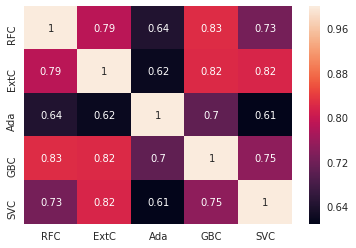

In [39]:
test.head()
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [40]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [41]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

/home/bijan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
